## ch06 Model Complexity & Hyperparameters
- https://github.com/mattharrison/effective_xgboost_book/blob/main/xgbcode.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.7.20</div>
<div style="text-align: right"> Last update: 2023.7.20</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

### 준비

In [2]:
import subprocess
def my_dot_export(xg, num_trees, filename, title='', direction='TB'):
    """Exports a specified number of trees from an XGBoost model as a graph 
    visualization in dot and png formats.

    Args:
        xg: An XGBoost model.
        num_trees: The number of tree to export.
        filename: The name of the file to save the exported visualization.
        title: The title to display on the graph visualization (optional).
        direction: The direction to lay out the graph, either 'TB' (top to 
            bottom) or 'LR' (left to right) (optional).
    """
    res = xgb.to_graphviz(xg, num_trees=num_trees)
    content = f'''    node [fontname = "Roboto Condensed"];
    edge [fontname = "Roboto Thin"];
    label = "{title}"
    fontname = "Roboto Condensed"
    '''
    out = res.source.replace('graph [ rankdir=TB ]', 
                             f'graph [ rankdir={direction} ];\n {content}')
    # dot -Gdpi=300 -Tpng -ocourseflow.png courseflow.dot 
    dot_filename = filename
    with open(dot_filename, 'w') as fout:
        fout.write(out)
    png_filename = dot_filename.replace('.dot', '.png')
    subprocess.run(f'dot -Gdpi=300 -Tpng -o{png_filename} {dot_filename}'.split())

In [3]:
raw = pd.read_csv("../../data/kaggle-survey-2018/raw.csv")
raw.shape

(23859, 395)

In [4]:
def tweak_kag(df_: pd.DataFrame) -> pd.DataFrame:
    """
    Tweak the Kaggle survey data and return a new DataFrame.

    This function takes a Pandas DataFrame containing Kaggle 
    survey data as input and returns a new DataFrame. The 
    modifications include extracting and transforming certain 
    columns, renaming columns, and selecting a subset of columns.

    Parameters
    ----------
    df_ : pd.DataFrame
        The input DataFrame containing Kaggle survey data.

    Returns
    -------
    pd.DataFrame
        The new DataFrame with the modified and selected columns.
    """  
    return (df_
            .assign(age = df_.Q2.str.slice(0, 2).astype(int),
                    education = df_.Q4.replace({
                        'Master’s degree': 18,
                        'Bachelor’s degree': 16,
                        'Doctoral degree': 20,
                        'Some college/university study without earning a bachelor’s degree': 13,
                        'Professional degree': 19,
                        'I prefer not to answer': None,
                        'No formal education past high school': 12}),
                    major = (df_.Q5
                             .pipe(topn, n = 3)
                             .replace({
                                 'Computer science (software engineering, etc.)': 'cs',
                                 'Engineering (non-computer focused)': 'eng',
                                 'Mathematics or statistics': 'stat'})
                             ),
                    years_exp = (df_.Q8.str.replace('+', '', regex=False)
                                 .str.split('-', expand=True)
                                 .iloc[:, 0]
                                 .astype(float)),
                    compensation=(df_.Q9.str.replace('+','', regex=False)
                           .str.replace(',','', regex=False)
                           .str.replace('500000', '500', regex=False)
                           .str.replace('I do not wish to disclose my approximate yearly compensation',
                                        '0', regex=False)
                           .str.split('-', expand=True)
                           .iloc[:,0]
                           .fillna(0)
                           .astype(int)
                           .mul(1_000)),
                    python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
                    r=df_.Q16_Part_2.fillna(0).replace('R', 1),
                    sql=df_.Q16_Part_3.fillna(0).replace('SQL', 1)
               )#assign
            .rename(columns=lambda col: col.replace(' ', '_'))
            .loc[:, 'Q1,Q3,age,education,major,years_exp,compensation,'
                 'python,r,sql'.split(',')]
            )

In [5]:
def topn(ser, n=5, default='other'):
    """
    Replace all values in a Pandas Series that are not among 
    the top `n` most frequent values with a default value.

    This function takes a Pandas Series and returns a new 
    Series with the values replaced as described above. The 
    top `n` most frequent values are determined using the 
    `value_counts` method of the input Series.

    Parameters
    ----------
    ser : pd.Series
        The input Series.
    n : int, optional
        The number of most frequent values to keep. The 
        default value is 5.
    default : str, optional
        The default value to use for values that are not among 
        the top `n` most frequent values. The default value is 
        'other'.

    Returns
    -------
    pd.Series
        The modified Series with the values replaced.
    """    
    counts = ser.value_counts()
    return ser.where(ser.isin(counts.index[:n]), default)

In [6]:
from feature_engine import encoding, imputation
from sklearn import base, pipeline

In [7]:
class TweakKagTransformer(base.BaseEstimator,
    base.TransformerMixin):
    """
    A transformer for tweaking Kaggle survey data.

    This transformer takes a Pandas DataFrame containing 
    Kaggle survey data as input and returns a new version of 
    the DataFrame. The modifications include extracting and 
    transforming certain columns, renaming columns, and 
    selecting a subset of columns.

    Parameters
    ----------
    ycol : str, optional
        The name of the column to be used as the target variable. 
        If not specified, the target variable will not be set.

    Attributes
    ----------
    ycol : str
        The name of the column to be used as the target variable.
    """

    def __init__(self, ycol=None):
        self.ycol = ycol

    def transform(self, X):
        return tweak_kag(X)

    def fit(self, X, y=None):
        return self

In [8]:
def get_rawX_y(df, y_col):
    raw = (df
            .query('Q3.isin(["United States of America", "China", "India"]) '
               'and Q6.isin(["Data Scientist", "Software Engineer"])')
          )
    return raw.drop(columns=[y_col]), raw[y_col]

In [9]:
kag_pl = pipeline.Pipeline(
    [('tweak', TweakKagTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True,
                                       variables=['Q1', 'Q3', 'major'])),
     ('num_inpute', imputation.MeanMedianImputer(imputation_method='median',
                                                    variables=['education', 'years_exp']))]
) 

In [10]:
from sklearn import model_selection

In [11]:
kag_X, kag_y = get_rawX_y(raw, 'Q6')

In [12]:
kag_X_train, kag_X_test, kag_y_train, kag_y_test = model_selection.train_test_split(
    kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [13]:
X_train = kag_pl.fit_transform(kag_X_train, kag_y_train)
X_test = kag_pl.transform(kag_X_test)

### 6.1 Underfit

앞의 stump는 너무 심플하다. 통계학에서는 이를 바이어스가 크다고 한다.   
또는 언더핏이라고 한다.   
우리 모델은 하나의 컬럼만 바라보고 있는 형태이다.   
추가적인 R 컬럼을 확인한 후에 다른 컬럼을 확인할 수 있다면 성능을 높일 수 있을 것이다.    

언더핏을 개선하는 방법은 다음과 같다.  
- 피처 추가
- 복잡한 모델 사용

베이스라인 모델을 확인하자.

In [14]:
import sklearn.tree as tree

In [15]:
underfit = tree.DecisionTreeClassifier(max_depth=1)
X_train = kag_pl.fit_transform(kag_X_train)
underfit.fit(X_train, kag_y_train)
underfit.score(X_test, kag_y_test)

0.6243093922651933

### 6.2 Growing a Tree

그루터기를 만드는 방법을 보여드렸습니다. 맞지 않는 그루터기는 어떻게 수정하나요? 학습 데이터에 고급 기능(또는 열)을 추가하여 클래스를 더 잘 구분할 수 있습니다. 또는 나무를 더 크게 성장시켜 그루터기를 더 복잡하게 만들 수도 있습니다.

일반적으로 임의의 방법을 시도하는 대신 조금 더 체계적인 방식으로 진행하는 것이 좋습니다. 한 가지 일반적인 기법은 나무를 더 깊게 자라게 하거나 트리를 더 깊게 성장시키거나 열을 추가하여 모델 정확도를 측정하고 개선이 있는지 확인하는 것입니다. 다음을 수행할 수 있습니다. 제약 조건이 주어진 채점 함수를 최적화합니다. 모델마다 다른 채점 함수를 사용할 수 있습니다. 직접 만들 수도 있습니다. 우리는 scikit-learn이 지니를 최적화하는 것을 보았습니다. XGBoosts는 손실 함수에 대해 경사 하강을 수행합니다.   

모델에 대한 제약 조건을 하이퍼파라미터라고 합니다. 하이퍼파라미터는 높은 수준에서 모델의 복잡성을 제어하는 데 사용할 수 있는 손잡이입니다. 우리의 그루터기가 너무 단순해서 데이터에 적합하지 않다는 것을 기억하세요. 트리 기반 모델에 복잡성을 추가하는 한 가지 방법은 노드를 더 늘리는 것입니다. 하이퍼파라미터를 사용하여 노드를 추가하는 방법과 시기를 결정할 수 있습니다.

### 6.3 Overfitting

모델을 최적화하기 전에 다른 쪽 끝인 과적합 모델에 대해 살펴봅시다. 과적합 모델은 너무 복잡합니다. 다시 말하지만, 통계학자는 분산이 너무 많다고 말할 것입니다. 저는 인터뷰 상황이 아니라면 '분산'이라는 용어를 너무 많이 사용하지 않으며, 데이터의 구석구석을 살펴보는 모델을 상상하는 것을 좋아합니다. 새로운 예제를 발견하면 모델이 학습 데이터를 검사하여 학습한 모든 사소한 측면을 비교하기 때문에 잘못된 길로 인도하는 경향이 있습니다. 올바른 레이블을 찾아내는 대신 복잡성 때문에 레이블이 '달라지게' 되는 것입니다.

과적합을 처리하는 데 도움이 되는 일반적인 해결책이 있습니다:
- 단순화 또는 제약(정규화) 
- 샘플(데이터 행)을 더 추가합니다.

트리 모델의 경우 잎 노드가 지나치게 특정되도록 성장을 잘라낼 수 있습니다. 이렇게 하면 모델이 단순화되거나 제한됩니다. 또는 더 많은 데이터를 수집하여 모델이 중요한 특징을 찾기 위해 더 많은 시도를 하도록 할 수 있습니다.

### 6.4 Overfitting with Decision trees

In [16]:
hi_variance = tree.DecisionTreeClassifier(max_depth=None)
X_train = kag_pl.fit_transform(kag_X_train)
hi_variance.fit(X_train, kag_y_train)
hi_variance.score(X_test, kag_y_test)

0.6629834254143646

이 경우 정확도는 66%입니다. 그루터기의 정확도는 62%였습니다. 복잡한 모델을 단순화하거나 간단한 모델에 약간의 복잡성을 추가하면 그루터기와 복잡한 모델 모두보다 더 나은 정확도를 얻을 수 있습니다(그리고 그럴 가능성이 높습니다).

다음은 복잡한 모델의 시각화입니다. 나무가 꽤 깊다는 것을 알 수 있습니다. 노드의 레벨이 22개입니다. 이 시각화는 오버핏 트리가 왜 나쁜지 직관적으로 이해하는 데 도움이 될 것입니다. 기본적으로 학습 데이터를 암기하는 것입니다. 이전에 본 데이터와 정확히 같지 않은 데이터를 입력하면 잘못된 방향으로 나아가는 경향이 있습니다. (데이터를 암기하는 것이 좋다고 생각한다면 가능한 모든 입력을 암기하고 그에 대한 거대한 if 문을 만들면 되므로 머신 러닝 모델이 필요하지 않습니다.)

[Text(0.6597852961525938, 0.9761904761904762, 'r <= 0.5\ngini = 0.496\nsamples = 2110\nvalue = [1153, 957]'),
 Text(0.4007988862057738, 0.9285714285714286, 'major_cs <= 0.5\ngini = 0.493\nsamples = 1484\nvalue = [653, 831]'),
 Text(0.19592467983503364, 0.8809523809523809, 'Q3_United States of America <= 0.5\ngini = 0.49\nsamples = 718\nvalue = [410, 308]'),
 Text(0.08133004124158888, 0.8333333333333334, 'years_exp <= 0.5\ngini = 0.491\nsamples = 322\nvalue = [140, 182]'),
 Text(0.026481441285001087, 0.7857142857142857, 'education <= 17.0\ngini = 0.463\nsamples = 74\nvalue = [47, 27]'),
 Text(0.01996961146082049, 0.7380952380952381, 'age <= 27.5\ngini = 0.499\nsamples = 40\nvalue = [21, 19]'),
 Text(0.018233123507705666, 0.6904761904761905, 'major_stat <= 0.5\ngini = 0.5\nsamples = 38\nvalue = [19, 19]'),
 Text(0.01649663555459084, 0.6428571428571429, 'compensation <= 55000.0\ngini = 0.498\nsamples = 36\nvalue = [17, 19]'),
 Text(0.014760147601476014, 0.5952380952380952, 'compensation <

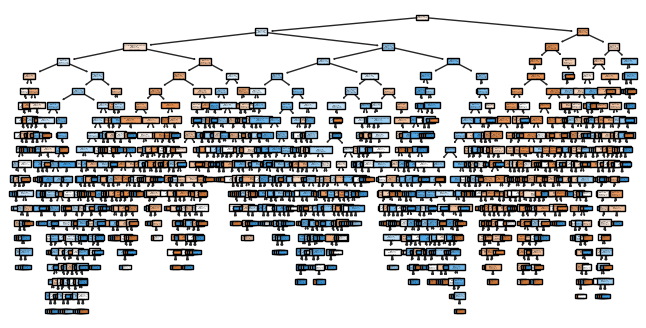

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(hi_variance, feature_names=features, filled=True)

줌인을 해보자.

[Text(0.5, 0.875, 'r <= 0.5\ngini = 0.496\nsamples = 2110\nvalue = [1153, 957]\nclass = Data Scientist'),
 Text(0.25, 0.625, 'major_cs <= 0.5\ngini = 0.493\nsamples = 1484\nvalue = [653, 831]\nclass = Software Engineer'),
 Text(0.125, 0.375, 'Q3_United States of America <= 0.5\ngini = 0.49\nsamples = 718\nvalue = [410, 308]\nclass = Data Scientist'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'years_exp <= 2.5\ngini = 0.433\nsamples = 766\nvalue = [243, 523]\nclass = Software Engineer'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'major_cs <= 0.5\ngini = 0.322\nsamples = 626\nvalue = [500, 126]\nclass = Data Scientist'),
 Text(0.625, 0.375, 'years_exp <= 22.5\ngini = 0.211\nsamples = 443\nvalue = [390, 53]\nclass = Data Scientist'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'years_exp <= 7.5\ngini = 0.48\nsamples = 183\nval

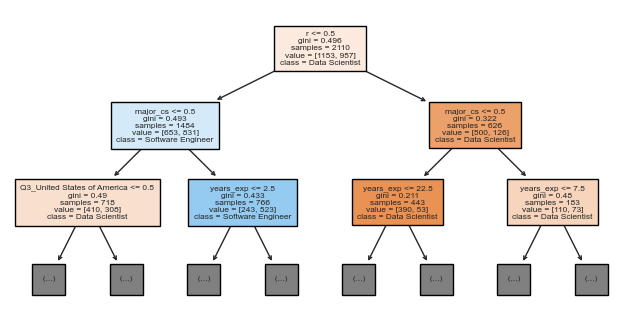

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(hi_variance, feature_names=features, filled=True,
class_names=hi_variance.classes_,
max_depth=2, fontsize=6)

- 진한 주황색 상자는 데이터 과학자가 많고, 파란색 상자는 소프트웨어 엔지니어입니다. 가장 주황색인 경로를 따라가면 맨 위 노드에 컴퓨터 공학을 전공하지 않았고, 마지막으로 경력이 22.5년 이하인 R을 사용하는 사람이 있습니다. 이 버킷에 속하는 사람 중 443개의 샘플 중 390명이 데이터 과학자였습니다.

의사 결정 트리를 해석하는 능력은 중요하고 종종 비즈니스에 결정적인 역할을 합니다. 많은 기업이 모델의 동작에 대한 구체적인 설명을 제공하기 위해 모델 성능을 기꺼이 희생합니다. 의사 결정 트리는 이를 매우 쉽게 만듭니다. XGBoost 모델은 간단한 해석을 제공하는 데 더 많은 어려움을 겪는다는 것을 알게 될 것입니다.